# STOR 566, Homework 4
### Instructor: Yao Li
### Keywords: VAE, GAN
### Due date: Oct 16, 11:55pm
### **Submission Instruction**

- Please download this script and use it to answer the questions in the homework. 
- For submission, please include your code, code output and answers in the script and submit the ipynb file on sakai.
- Please don't modify existing cells. But you can add cells between the exercise statements.
- To make markdown, please switch the cell type to markdown (from code) - you can hit 'm' when you are in command mode - and use the markdown language. For a brief tutorial see: https://daringfireball.net/projects/markdown/syntax

### **References:**

- You can follow the setup instructions at [here](https://pytorch.org/get-started/locally/).
- A useful tutorial on learning pytorch by examples at [here](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html).
- Check Pytorch optimization methods at [here](https://pytorch.org/docs/stable/optim.html).
- Check Pytorch DC-GAN tutorial at [here](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).


### **Evaluation Metrics of Generator:**

- [Fréchet Inception Distance](https://arxiv.org/pdf/1706.08500.pdf): compares the distribution of generated images with the distribution of a set of real images

    - Code Reference: https://pytorch-ignite.ai/blog/gan-evaluation-with-fid-and-is/

- [Inception Score](https://arxiv.org/abs/1606.03498): measures two things simultaneously

    - The images have variety (e.g. each image is a different breed of dog)
    - Each image distinctly looks like something (e.g. one image is clearly a Poodle, the next a great example of a French Bulldog)
    - Code Reference: https://pytorch-ignite.ai/blog/gan-evaluation-with-fid-and-is/

## Problem 1 (40 points)

In this problem you will practice implementing Variational Auto-Encoder (VAE) on MNIST data set.

**Data.** You will use MNIST digit classification dataset. Pytorch/torchvision has provide a useful dataloader to automatically download and load the data into batches. Code of the data loader has been provided in the template. Please don't modify the data loading part.

In [ ]:

# You need package pytorch-ignite for the last question
# To avoid loading it every time, you can install pytorch-ignite to a path on google drive
import os
from google.colab import drive
drive.mount('/content/drive')
pkg_path = '/content/drive/MyDrive/DIR_FOR_PKGS'
!pip install --target=$pkg_path pytorch-ignite

# Append the path to the sys path to load the pkg without re-installation
import sys
pkg_path = '/content/drive/MyDrive/DIR_FOR_PKGS'
sys.path.append(pkg_path)
import ignite.distributed as idist
from ignite.engine import Engine, Events
from ignite.metrics import FID, InceptionScore


Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 264 kB 4.7 MB/s 
     |████████████████████████████████| 776.3 MB 13 kB/s 
     |████████████████████████████████| 40 kB 5.6 MB/s 
     |████████████████████████████████| 98 kB 8.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.1.2 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.
spacy 3.4.1 requires typing-extensions<4.2.0,>=3.7.4; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.
confection 0.0.2 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.4.0 which is incompatible.


In [ ]:
import time
import torch

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torch.utils.data as td
import random, time
import matplotlib.pyplot as plt
import torchvision
import PIL.Image as Image
from torchvision.utils import save_image
# import ignite.distributed as idist
# from ignite.engine import Engine, Events
# from ignite.metrics import FID, InceptionScore
from torchvision import datasets, transforms
#device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
if not os.path.exists('./vae_img'):
    os.mkdir('./vae_img')


def to_img(x):
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [ ]:
## Data loading code chunk, please don't modify it. 
## However, you can adjust the batch size if you want to.
batch_size = 128

def mnist_loaders(batch_size): 
    data_dir = './data'
    train_data = datasets.MNIST(data_dir, train=True, download=True,
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                      ]))
    # Once you have downloaded the data by setting download=True, you can
    # change download=True to download=False
    test_data = datasets.MNIST(data_dir, train=False, download=False,
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                      ]))
    train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size, 
      shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size, 
      shuffle=False)
    return train_loader, test_loader

train_mnist_loader, test_mnist_loader = mnist_loaders(batch_size)

### **Problem Description.** Implement **VAE** with Pytorch on MNIST.

### (a) (5 points) Print the model architecture.

In [ ]:
#code:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
 
 # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
 # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
 
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
 
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
 
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()
print(vae)


VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)


### (b) (5 points) Report the hyper-parameters (number of epochs, learning rate, momentum, weight_decay etc).

Answer:optimizer = optim.Adam(vae.parameters())
     epoch=50
     learning rate=0.1

### (c) (20 points) Report the **VAE Loss** after every training epoch by generating Loss vs. Epoch plot. Please report at least **10** epochs.

In [ ]:
#Code:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

def train(epoch):
    vae.train()
    train_loss = 0
    
    for batch_idx, (data, _) in enumerate(train_mnist_loader):
       # data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_mnist_loader.dataset),
                100. * batch_idx / len(train_mnist_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_mnist_loader.dataset)))
    if epoch % 1 == 0:
        save = to_img(recon_batch.cpu().data)
        save_image(save, './vae_img/image_{}.png'.format(epoch))
    return train_loss / len(train_mnist_loader.dataset)
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_mnist_loader:
            
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_mnist_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
loss1=[]
for epoch in range(1, 11):
    loss1.append(train(epoch))
    test()


Train Epoch: 1 [0/60000 (0%)]	Loss: 543.293518
Train Epoch: 1 [12800/60000 (21%)]	Loss: 192.316925
Train Epoch: 1 [25600/60000 (43%)]	Loss: 172.976700
Train Epoch: 1 [38400/60000 (64%)]	Loss: 169.766876
Train Epoch: 1 [51200/60000 (85%)]	Loss: 162.443817
====> Epoch: 1 Average loss: 183.2506
====> Test set loss: 164.4729
Train Epoch: 2 [0/60000 (0%)]	Loss: 170.654404
Train Epoch: 2 [12800/60000 (21%)]	Loss: 167.161484
Train Epoch: 2 [25600/60000 (43%)]	Loss: 155.703964
Train Epoch: 2 [38400/60000 (64%)]	Loss: 156.114777
Train Epoch: 2 [51200/60000 (85%)]	Loss: 154.740784
====> Epoch: 2 Average loss: 159.5889
====> Test set loss: 156.4339
Train Epoch: 3 [0/60000 (0%)]	Loss: 164.821701
Train Epoch: 3 [12800/60000 (21%)]	Loss: 159.104202
Train Epoch: 3 [25600/60000 (43%)]	Loss: 152.650833
Train Epoch: 3 [38400/60000 (64%)]	Loss: 154.546188
Train Epoch: 3 [51200/60000 (85%)]	Loss: 155.429382
====> Epoch: 3 Average loss: 153.8107
====> Test set loss: 152.2385
Train Epoch: 4 [0/60000 (0%)]	L

In [ ]:
loss1

[140.2886557454427,
 139.8788860514323,
 139.67556201171874,
 139.1676170735677,
 139.03687080078126,
 138.83784939778647,
 138.61881236979167,
 138.31571181640626,
 137.97343486328126,
 137.4078993326823]

range(1, 11)
[140.2886557454427, 139.8788860514323, 139.67556201171874, 139.1676170735677, 139.03687080078126, 138.83784939778647, 138.61881236979167, 138.31571181640626, 137.97343486328126, 137.4078993326823]


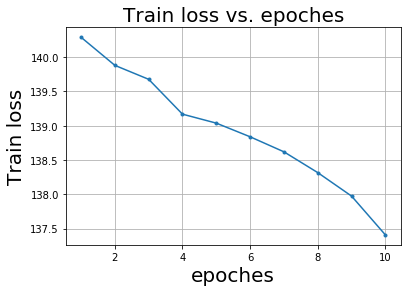

In [ ]:
#Plot:
def draw_loss(Loss_list,epoch):
    
    plt.cla()
    x1 = range(1, epoch+1)
    print(x1)
    y1 = Loss_list
    print(y1)
    plt.title('Train loss vs. epoches', fontsize=20)
    plt.plot(x1, y1, '.-')
    plt.xlabel('epoches', fontsize=20)
    plt.ylabel('Train loss', fontsize=20)
    plt.grid()
#     plt.savefig("./lossAndacc/Train_loss.png")
#     plt.savefig("./lossAndacc/Train_loss.png")
    plt.show()
draw_loss(loss1,10)


### (d) (10 points) Please apply the trained VAE model on a batch (128) of test samples and visualize both the test samples and reconstructed samples. Do the reconstructed samples look good?

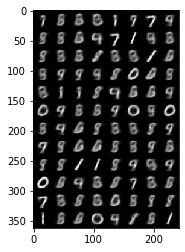

In [ ]:
#Code:
import cv2
spect= cv2.imread( './vae_img/image_1.png') # BGR
import matplotlib.pyplot as plt
plt.imshow(spect)
plt.show()

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2,
        5, 4, 7, 6, 7, 9, 0, 5])
torch.Size([128])


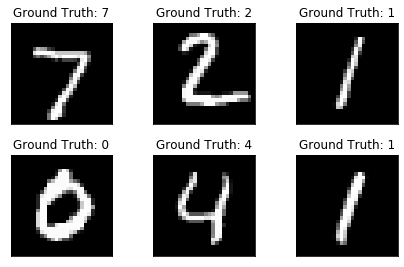

In [ ]:
examples = enumerate(test_mnist_loader) #img&label
batch_idx, (imgs, labels) = next(examples) 

print(labels) #
print(labels.shape) 

import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(imgs[i][0], cmap='gray', interpolation='none')#
    plt.title("Ground Truth: {}".format(labels[i])) #title
    plt.xticks([])
    plt.yticks([])


Answer:It almost the same with the original minst

## Problem 2 (60 points)

In this problem you will practice implementing DC-GAN on CIFAR10 data set.

**Data.** You will use CIFAR10 classification dataset (10 classes). Pytorch/torchvision has provide a useful dataloader to automatically download and load the data into batches. Code of the data loader has been provided in the template. Please don't modify the data loading part.

In [ ]:
## Data loading code chunk, please don't modify it. 
## However, you can adjust the batch size if you want to.
batch_size_cifar = 128

def cifar_loaders(batch_size, shuffle_test=False): 
    data_dir = './data'
    train = datasets.CIFAR10(data_dir, train=True, download=True, 
        transform=transforms.Compose([
            transforms.ToTensor(),
        ]))
    # Once you have downloaded the data by setting download=True, you can
    # change download=True to download=False
    test = datasets.CIFAR10(data_dir, train=False, 
        transform=transforms.Compose([transforms.ToTensor()]))
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size,
        shuffle=True, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size,
        shuffle=shuffle_test, pin_memory=True)
    return train_loader, test_loader

train_cifar_loader, test_cifar_loader = cifar_loaders(batch_size_cifar)


Extracting ./data\cifar-10-python.tar.gz to ./data


In [ ]:
dataroot =  r"/Users/jiyuchen/Downloads"
dataset = torchvision.datasets.CIFAR10(root=dataroot, train=True,
                                        download=True, transform=transforms.Compose([
                                           transforms.Resize(image_size),
                                           transforms.CenterCrop(image_size),
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                       ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=True)


Files already downloaded and verified


### **Problem Description.** Implement **DC-GAN** with Pytorch on CIFAR10.

### (a) (5 points) Print the model architecture (discriminator and generator).

In [ ]:
#Code:from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torchvision
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
cudnn.benchmark = True


batch_size = 128  


image_size = 64  
nc = 3 
nz = 100  
ngf = 64  
ndf = 64  
num_epochs = 10  
lr = 0.0002  
beta1 = 0.5  
ngpu = 0

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            
        )

    def forward(self, input):
        return self.main(input)
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
netG = Generator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))


netG.apply(weights_init)


print(netG)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

netD = Discriminator(ngpu).to(device)


if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weights_init)

print(netD)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
netD = Discriminator(ngpu=0)
print(netD)

Random Seed:  999
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (

### (b) (20 points) Report the **Generator Loss** and **Discriminator Loss** after every training epoch by generating Loss vs. Epoch plot. Please report at least **10** epochs and include two curves in the same plot with legend.

In [ ]:
criterion = nn.BCELoss()


fixed_noise = torch.randn(64, nz, 1, 1, device=device)


real_label = 1
fake_label = 0


optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))




img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):
    
    for i, data in enumerate(dataloader, 0):

        
        netD.zero_grad()
  
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        label=label.to(torch.float)
       
        output = netD(real_cpu).view(-1)
        
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        
        output = netD(fake.detach()).view(-1)
        
        errD_fake = criterion(output, label)
        
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        errD = errD_real + errD_fake
        optimizerD.step()

       
        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(fake).view(-1)

        errG = criterion(output, label)

        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()


        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

       
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/10][0/391]	Loss_D: 1.3642	Loss_G: 4.0625	D(x): 0.5680	D(G(z)): 0.5362 / 0.0195
[0/10][50/391]	Loss_D: 0.0490	Loss_G: 7.9600	D(x): 0.9583	D(G(z)): 0.0003 / 0.0004
[0/10][100/391]	Loss_D: 0.6063	Loss_G: 3.3643	D(x): 0.9695	D(G(z)): 0.3961 / 0.0468
[0/10][150/391]	Loss_D: 0.1205	Loss_G: 2.8999	D(x): 0.9224	D(G(z)): 0.0324 / 0.0742
[0/10][200/391]	Loss_D: 0.2902	Loss_G: 5.3929	D(x): 0.8474	D(G(z)): 0.0969 / 0.0052
[0/10][250/391]	Loss_D: 0.4112	Loss_G: 3.8420	D(x): 0.8380	D(G(z)): 0.1387 / 0.0302
[0/10][300/391]	Loss_D: 0.3080	Loss_G: 4.5532	D(x): 0.7766	D(G(z)): 0.0217 / 0.0156
[0/10][350/391]	Loss_D: 0.3297	Loss_G: 4.9564	D(x): 0.8765	D(G(z)): 0.1609 / 0.0088
[1/10][0/391]	Loss_D: 0.7876	Loss_G: 5.5494	D(x): 0.8538	D(G(z)): 0.4428 / 0.0046
[1/10][50/391]	Loss_D: 0.2331	Loss_G: 3.5807	D(x): 0.9181	D(G(z)): 0.1316 / 0.0322
[1/10][100/391]	Loss_D: 2.5656	Loss_G: 4.0320	D(x): 0.1533	D(G(z)): 0.0001 / 0.0336
[1/10][150/391]	Loss_D: 0.2544	Loss_G: 4.4347	D(x): 0.90

In [ ]:
#Plot:

### (c) (10 points) Please use the trained DC-GAN model to generate a batch (64) new samples and visualize the generated samples. How do they look? Do they look like real samples?

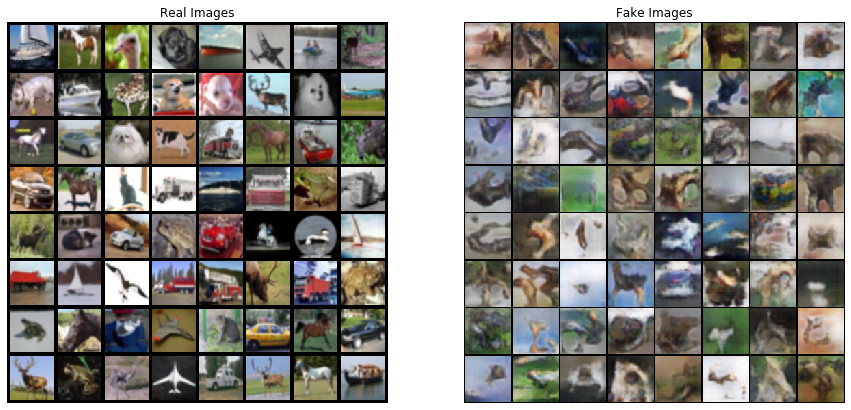

In [ ]:
import torchvision.utils as vutils
#Code:
real_batch = next(iter(dataloader))


plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))


plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

Answer：they look almost the same

### (d) (25 points) Please evaluate the trained DC-GAN model using Fréchet Inception Distance (FID) and Inception Score (IS) on the testset. 

In [ ]:
#Code:
mu1=torch.randn(b_size, nz, 1, 1, device=device)
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    '''Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an 
               representive data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an 
               representive data set.
    Returns:
    --   : The Frechet Distance.
    '''

    mu1 = np.atleast_1d(mu1)
    mu2 = np.at